In [20]:
import pandas as pd
import torch
from torch import nn, optimf

from sklearn.metrics import mean_squared_error

ImportError: cannot import name 'optimf' from 'torch' (/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/torch/__init__.py)

In [33]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [37]:
TEST_METRICS = {'mse': mean_squared_error}

In [58]:
class BtMLP(nn.Module):
    """
    Simple MLP implementation with PyTorch, attempting to mirror the Weber et al. implementation
    as closely as possible.
    """

    def __init__(self, train_X, train_y, n_hidden_layers = 1, hidden_layer_size = 50):
        super(BtMLP, self).__init__()
        
        # save training data
        self.train_X = train_X
        self.train_y = train_y

        # convert data to numpy if dataframes given
        if isinstance(self.train_X, pd.DataFrame):
            self.train_X = self.train_X.to_numpy()
            self.train_y = self.train_y.to_numpy()

        # get input size from training data
        input_size = self.train_X.shape[1]

        # init the model
        self.model = nn.Sequential()

        # add input layer
        self.model.add_module(f'input', nn.Linear(input_size, hidden_layer_size))
        self.model.add_module(f'relu_{0}', nn.ReLU())

        # populate hidden layers
        for i in range(n_hidden_layers):
            self.model.add_module(f'hidden_{i}', nn.Linear(hidden_layer_size, hidden_layer_size))
            self.model.add_module(f'relu_{i + 1}', nn.ReLU())
        
        # output layer
        self.model.add_module('output', nn.Linear(hidden_layer_size, 1))
    
    def forward(self, X):
        return self.model(X)
    
    def predict(self, X):

        # convert X to tensor
        X_in = torch.FloatTensor(X)

        out = self.model(X_in)
        return out.detach().numpy()
        # return np.array([
        #     0 if out[i][0] <= 0.5 else 1 for i in range(len(out))
        # ])
    
    def test(self, given_X, given_y):

        # convert to numpy if necessary
        X = given_X if isinstance(given_X, np.ndarray) else given_X.to_numpy()
        y = given_y if isinstance(given_y, np.ndarray) else given_y.to_numpy()

        # get predicted values
        predicted = self.predict(X = X)

        # save the result of each metric
        return mean_squared_error(y, predicted)

In [ ]:
def train_model(model, train_X, train_y, 
    n_epochs = 200, learning_rate = 0.001, criterion = nn.MSELoss(), show_plot = True):

    # init optimizer
    optimizer = optim.Adam(model.model.parameters(), lr = learning_rate)

    # get training x as tensor
    model_input = torch.FloatTensor(train_X)

    # get target tensor
    target = torch.FloatTensor(train_y)

    # optimize
    losses = []
    for epoch in range(n_epochs):

        predicted = model(model_input)
        optimizer.zero_grad()
        loss = criterion(predicted, target)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    
    # plot loss over time
    if show_plot:
        
        losses = [l.detach().numpy() for l in losses]
        plt.figure(figsize = (20, 5))
        plt.subplot(131)
        plt.plot(losses)
        plt.show()

In [60]:
fname = '../data/sample_gc_level_prediction_data.csv'
data = pd.read_csv(fname)
data.head()

,is_gt,num_p0,num_p1,num_p2,num_p3,num_p4,num_p5,points_scale,num_itt,itt_kms,top10_mean
0,0.0,0.0,0.044205,0.000000,0.034421,0.0,0.02527,0.02132,0.0,0.0,1508.409260
1,0.0,0.0,0.022102,0.019597,0.034421,0.0,0.02527,0.02132,0.0,0.0,1511.514542
2,0.0,0.0,0.022102,0.019597,0.000000,0.0,0.02527,0.02132,0.0,0.0,1502.589237
3,0.0,0.0,0.022102,0.039193,0.000000,0.0,0.02527,0.04264,0.0,0.0,1504.357642
4,0.0,0.0,0.000000,0.039193,0.034421,0.0,0.02527,0.04264,0.0,0.0,1499.619490


In [69]:
train_split = int(0.75 * len(data.index))
train_X = data.drop(columns = ['top10_mean']).iloc[0: train_split, :].to_numpy()
train_y = data['top10_mean'].iloc[0: train_split].to_numpy()

test_X = data.drop(columns = ['top10_mean']).iloc[train_split: , :].to_numpy()
test_y = data['top10_mean'].iloc[train_split: ].to_numpy()

In [82]:
for nl in range(8):
    for size in [200]:
        mlp = BtMLP(train_X, train_y, n_hidden_layers = nl, hidden_layer_size = size)
        train_model(mlp, mlp.train_X, mlp.train_y, n_epochs = 1000, show_plot = False)

        err = mlp.test(test_X, test_y)
        print(f'Num Layers: {nl}, Layer size: {size}: ', round(err, 2))

Num Layers: 0, Layer size: 200:  1381969.22
Num Layers: 1, Layer size: 200:  80171.39
Num Layers: 2, Layer size: 200:  7287.02
Num Layers: 3, Layer size: 200:  933.66
Num Layers: 4, Layer size: 200:  890.03
Num Layers: 5, Layer size: 200:  1043.99
Num Layers: 6, Layer size: 200:  994.46
Num Layers: 7, Layer size: 200:  992.77


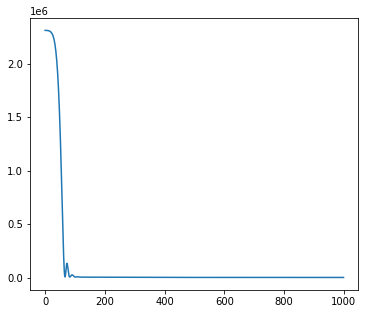

Test result: 900.7404159920161


In [90]:
mlp4 = BtMLP(train_X, train_y, n_hidden_layers = 3, hidden_layer_size = 200)
train_model(mlp4, mlp4.train_X, mlp4.train_y, n_epochs = 1000)
print('Test result:', mlp4.test(test_X, test_y))

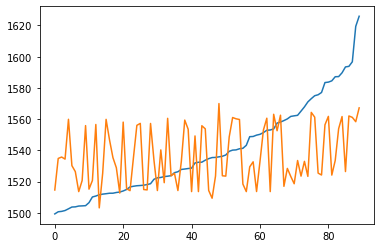

In [98]:
out_test_X = mlp4(torch.FloatTensor(test_X)).detach().numpy()
res = list(zip([v[0] for v in out_test_X], test_y))
res.sort(key = lambda t: t[1])
plt.plot([r[1] for r in res])
plt.plot([r[0] for r in res])